In [1]:
#Importing unityEnvironment work simulation to be done here along with numpy

from unityagents import UnityEnvironment
import numpy as np

In [2]:
#Loading Unity Environment with the downloaded environment app files

env = UnityEnvironment(file_name='Tennis.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

brain_name, brain

('TennisBrain', <unityagents.brain.BrainParameters at 0x1167a0160>)

In [4]:
env_info = env.reset(train_mode=True)[brain_name]
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
num_states = len(env_info.vector_observations[0])

num_agents,action_size,num_states

(2, 2, 24)

In [5]:
from ddpg_agent import Agent

agent = Agent(num_states, action_size,0,num_agents)
agent

In [6]:
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
env_info = env.reset(train_mode=True)[brain_name]

Episode 692	Average Score: 0.51
Environment solved in 692 episodes!	Average Score: 0.51


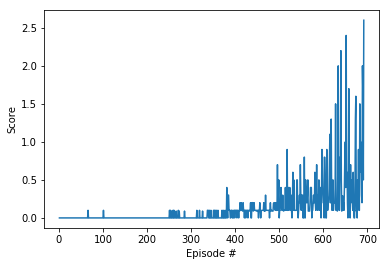

In [8]:
update_num = 1

def ddpg(n_episodes=2000,max_t=1000,print_every=100,toggle=False):
    
    #To keep track of the most recent scores for the environment
    scores_deque = deque(maxlen=print_every)
    
    #To keep track of all scores from the environment
    scores = []
    
    #Epsilon values
    epsilon = 1
    epsilon_end = 0.05
    epsilon_decay = 1e-4
    
    #Learning from num_episodes using experience replay
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        
        #To reset noise for the episode
        agent.reset()
        to_update=1
        score = np.zeros(num_agents)
        
        for t in range(max_t):
            
            #Will return an array of actions that according to the policy are optimal, using the actor network
            actions = agent.act(states,epsilon)
            
            #Taking one step for each agent using the above obtained array of actions 
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            
            """
            Taking a step with the current set of states and actions which will be put to the 
            experience replay memory, and if the memory reaches a specific limit then the learning 
            will happen accordingly.
            """
            
            agent.step(states, actions, rewards, next_states, dones)
            
#             #Update networks every alternate step
#             if to_update:
#                 agent.update()
                
#             to_update = (to_update+1)%2

            for i in range(update_num):
                if to_update:
                    agent.update()
            
            if toggle:
                    to_update = (to_update+1)%2
                    
            #Preparing agent for next step
            states = next_states
            score += rewards
            
            #if any agent is done with their respective episode, then break
            if np.any(dones):
                break
        
        #Update epsilon
        epsilon = max(epsilon-epsilon_decay,epsilon_end)
        
        #Append mean of scores for all agents to the score arrays
        scores_deque.append(np.amax(score))
        scores.append(np.amax(score))
        
        #Print average score after each episode
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        
        if np.mean(scores_deque)>=0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.
                  format(i_episode, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
    return scores
    

scores = ddpg()

#Plotting the graph with the mean scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [11]:
#Inference
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

agent = Agent(state_size=env_info.vector_observations.shape[1], action_size=brain.vector_action_space_size, 
              num_agents=env_info.vector_observations.shape[0],  random_seed=0)
#Since the model is trained on gpu, need to load all gpu tensors to cpu:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth', map_location=lambda storage, loc: storage))

scores_list = []
def ddpg_inference(n_episodes=10):
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment
        states = env_info.vector_observations                   # get the current states (for all agents)
        agent.reset() #reset the agent OU Noise
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        while True:
            actions = agent.act(states,0.05)
            env_info = env.step(actions)[brain_name]           # send all actions to the environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get rewards (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += rewards                                  # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
        print('Episode {}: {}'.format(i_episode, np.mean(scores)))
        scores_list.append(np.mean(scores))
    print('Mean score is: ', np.mean(np.array(scores_list)))

ddpg_inference()

Episode 1: 2.600000038743019
Episode 2: 2.600000038743019
Episode 3: 2.650000039488077
Episode 4: 2.600000038743019
Episode 5: 2.600000038743019
Episode 6: 2.650000039488077
Episode 7: 2.600000038743019
Episode 8: 2.600000038743019
Episode 9: 2.650000039488077
Episode 10: 2.600000038743019
Mean score is:  2.6150000389665364


In [12]:
env.close()